<a href="https://colab.research.google.com/github/rayhsu520/Stock-prediction/blob/master/QUANTREND_CODING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from sklearn import svm, neighbors
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from os import path
from sklearn.preprocessing import MinMaxScaler
import copy
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

#Haved some problem dealing with GPU support on Google Colab so I didn't use GPU
print(f"GPU Support: {torch.cuda.is_available()}")



GPU Support: False


In [0]:
def process_label(df):
    #the 30avg here is the 30avg of T+29 days since we want to predict it using the data at time T
    #we only analyze on adjested close to make it simple
    df['30avg'] = df['Adj Close'].rolling(window=30).mean()
    df['30avg'] = df['30avg'].shift(periods = -30)
    df.dropna(inplace = True)
    return df

In [0]:
def show_correlation(df):
    #this is some correlation test I ran to see the correlations between variables to '30avg'
    df_corr = df.corr()
    data = df_corr.values
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    heatmap = ax.pcolor(data, cmap = plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0]+0.5))
    ax.set_yticks(np.arange(data.shape[1]+0.5))

    
    column_labels = df_corr.columns
    row_labels = df_corr.index
    
    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    
    heatmap.set_clim(-1,1)
    plt.title('Correlation Table')
    plt.tight_layout()
    plt.show()

In [0]:
def process_training_data(df):
    df = process_label(df)
    show_correlation(df)
    #n_features is the feature I used for each time
    n_features = 1
    X = df['Adj Close']
    y = df['30avg']
    #Scalar is used to normalize the datas
    scaler = MinMaxScaler(feature_range=(0, 1))
    #All data were used to 
    scaler = scaler.fit(np.expand_dims(X, axis=1))
    X = scaler.transform(np.expand_dims(X, axis=1))
    y = scaler.transform(np.expand_dims(y, axis=1))
    
    return X,y, n_features, scaler

#Split the data to train, test, validation set
def train_test_validation_split(X, y, n_features):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=False)
    X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size = 0.5, shuffle=False)
    
    return X_train, X_test, y_train, y_test, X_valid, y_valid

#This funnction is used to create many to one training data for LSTM
def create_sequences(X_, y_ , seq_length):
    xs = []
    ys = []

    for i in range(len(X_)-seq_length-1):
        x = X_[i:(i+seq_length)]
        y = y_[i]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)


In [0]:
#LSTM network structure
class Net(torch.nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super().__init__()
        self.n_hidden = n_hidden 
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
        input_size=n_features,
        hidden_size=n_hidden,
        num_layers=n_layers,
        dropout=0.5, batch_first = True
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    
    def forward(self, sequences):
        h_0 = Variable(torch.zeros(self.n_layers, sequences.size(0), self.n_hidden))
        c_0 = Variable(torch.zeros(self.n_layers, sequences.size(0), self.n_hidden))
        
        ula, (h_out, _) = self.lstm(sequences, (h_0, c_0))
        h_out = h_out.view(-1, self.n_hidden)
        y_pred = self.linear(h_out)
        return y_pred


#This function is used to adjust the learning rate through epoch
def adjust_learning_rate(optimizer, epoch, learning_rate):
    """Sets the learning rate to the initial LR decayed by 10 every 70 epochs"""
    learning_rate = learning_rate * (0.1 ** (epoch // 70))
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    return optimizer

In [0]:
def do_ML(model, X_train, y_train, X_test , y_test ):
    #process the data into tensors

    learning_rate = 0.001
    EPOCH = 180
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_func = torch.nn.MSELoss()

    #USE_CUDA if it is avaliable
    USE_CUDA = torch.cuda.is_available()
    if USE_CUDA:
        model = model.cuda()

        print("Using GPU")
    else:
        print("Not using GPU")
    

    #These are used to plot the loss through the training process
    train_hist = np.zeros(EPOCH)
    test_hist = np.zeros(EPOCH)
    
    min_loss = float('inf')
    best_model = None
    model.train()
    for epoch in range(EPOCH):
        optimizer = adjust_learning_rate(optimizer, epoch, learning_rate)
        if USE_CUDA:
          X_train = X_train.cuda()
          y_train = y_train.cuda()
          X_test = X_test.cuda()
          y_test  = y_test.cuda()


        y_pred = model(X_train)
        
        loss = loss_func(y_pred.float(), y_train)
        
        #Valid on test data
        with torch.no_grad():
            y_test_pred = model(X_test)
            test_loss = loss_func(y_test_pred.float(), y_test)
            test_hist[epoch] = test_loss.item()
            #Save the best model that has the lowest testing loss
            if test_loss < min_loss:
              min_loss = test_loss
              best_model = copy.deepcopy(model)
 
        if epoch % 10 == 0:  
            print(f'Epoch {epoch} train loss: {loss.item()} test loss: {test_loss.item()}')
            test_evaluation(model, X_train, y_train, scaler, 'Training Data')
            
        train_hist[epoch] = loss.item()

        #update parameter
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      
    if best_model:
      return best_model, train_hist, test_hist
    else:
      return model, train_hist, test_hist



In [0]:
#This is used to visualize the performance of the model
def test_evaluation(model, X_, y_, scaler, tytle):
    predict_seq = []
    model.eval()
    with torch.no_grad():
        y_pred = model(X_)
    
    true_cases = scaler.inverse_transform(
    np.expand_dims(y_.flatten().numpy(), axis=0)).flatten()

    
    predicted_cases = scaler.inverse_transform(
    np.expand_dims(y_pred.flatten(), axis=0)).flatten()

    index = np.arange(X_.shape[0])
    
    plt.plot(
    index, 
    true_cases,
    label='Real Daily Cases'
    )

    plt.plot(
    index, 
    predicted_cases, 
    label='Predicted Daily Cases'
    )
    plt.title(tytle + ' Evaluation')
    plt.legend()
    plt.show()

In [0]:
def plot_loss(train_hist, test_hist):
    plt.plot(train_hist, label = "Training Loss")
    plt.plot(test_hist, label = "Testing Loss")
    plt.ylim((0,1))
    plt.title('Loss Through Epoch')
    plt.legend();
    plt.show()

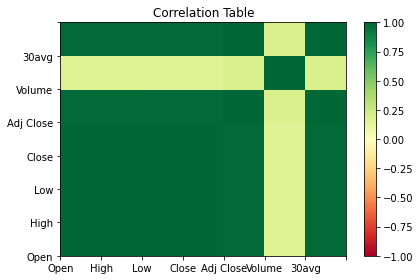

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Not using GPU
Epoch 0 train loss: 0.0631113201379776 test loss: 0.25179803371429443


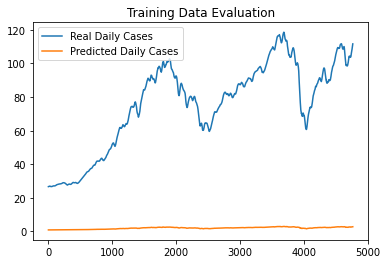

Epoch 10 train loss: 0.010995284654200077 test loss: 0.03029215708374977


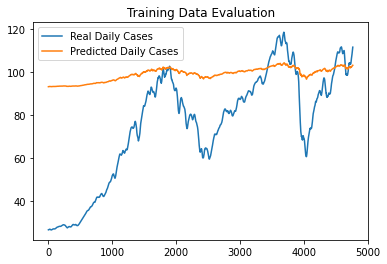

Epoch 20 train loss: 0.006615700200200081 test loss: 0.07826939970254898


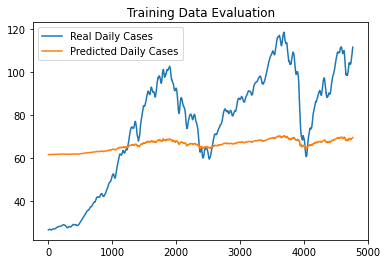

Epoch 30 train loss: 0.005203593987971544 test loss: 0.05720767006278038


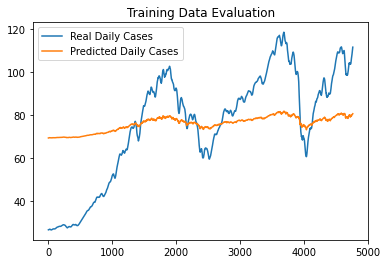

Epoch 40 train loss: 0.004873107187449932 test loss: 0.04716457054018974


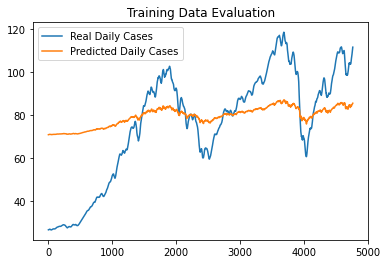

Epoch 50 train loss: 0.004373958799988031 test loss: 0.04915519431233406


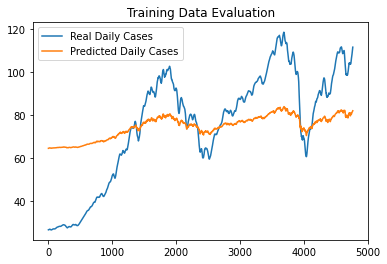

Epoch 60 train loss: 0.0035914022009819746 test loss: 0.032932206988334656


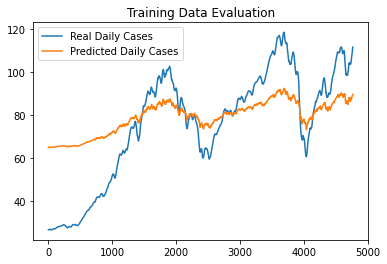

Epoch 70 train loss: 0.002162643475458026 test loss: 0.01512689609080553


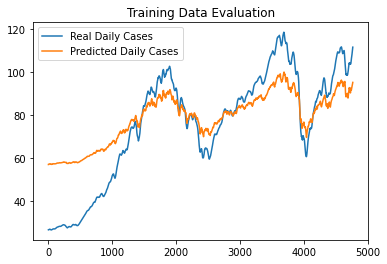

Epoch 80 train loss: 0.0019264515722170472 test loss: 0.012341952882707119


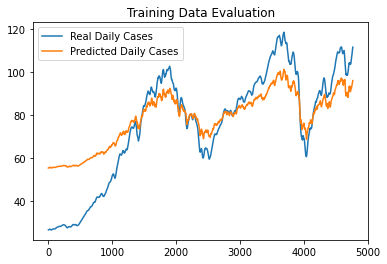

Epoch 90 train loss: 0.001651110826060176 test loss: 0.009297390468418598


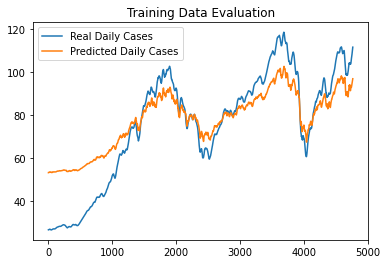

Epoch 100 train loss: 0.0013512102887034416 test loss: 0.005198176950216293


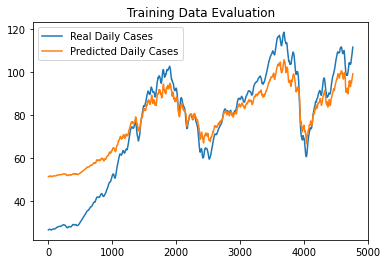

Epoch 110 train loss: 0.0010408851085230708 test loss: 0.0021410160697996616


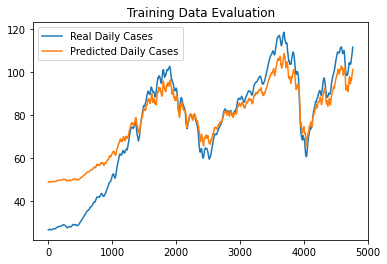

Epoch 120 train loss: 0.0007388894446194172 test loss: 0.00044197571696713567


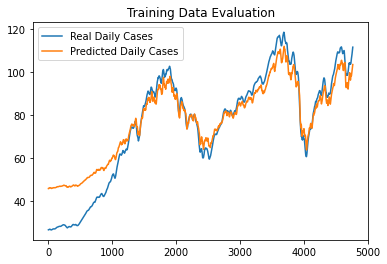

Epoch 130 train loss: 0.00047307516797445714 test loss: 0.0013479831395670772


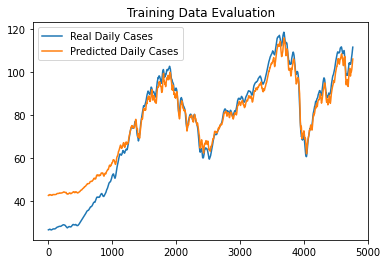

Epoch 140 train loss: 0.0002746411773841828 test loss: 0.005827368702739477


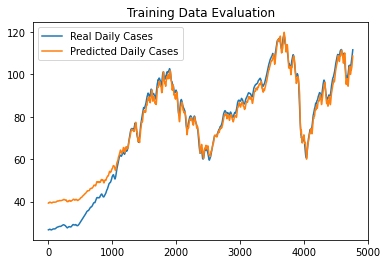

Epoch 150 train loss: 0.0002603707544039935 test loss: 0.006425957195460796


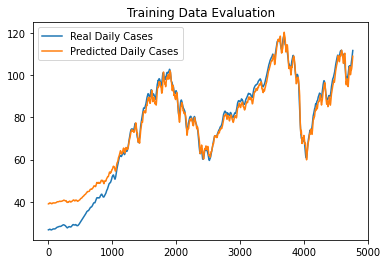

Epoch 160 train loss: 0.00024780991952866316 test loss: 0.006989968474954367


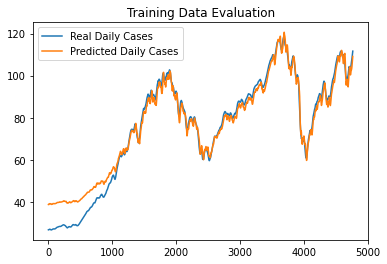

Epoch 170 train loss: 0.00023622307344339788 test loss: 0.007558145094662905


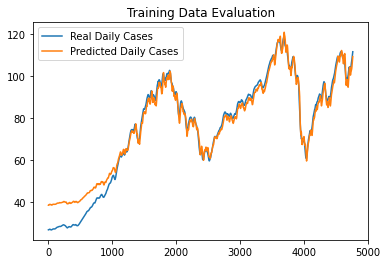

In [0]:
#---------------main----------
df = pd.read_csv('SPY.csv', index_col = 0)

#We need this scaler to reverse the normalized data
X,y, n_features, scaler = process_training_data(df)    
X_train, X_test, y_train, y_test, X_valid, y_valid = train_test_validation_split(X, y, n_features)
#This is the historical seq length
seq_length = 15

X_train, y_train = create_sequences(X_train, y_train, seq_length)
X_test, y_test = create_sequences(X_test, y_test, seq_length)
X_valid, y_valid = create_sequences(X_valid, y_valid, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
X_valid = torch.from_numpy(X_valid).float()
y_valid = torch.from_numpy(y_valid).float()

model = Net(n_features = 1, n_hidden = 165, seq_len = seq_length, n_layers = 1)
#the histogram records the loss
model, train_hist, test_hist = do_ML(model, X_train, y_train, X_test, y_test)

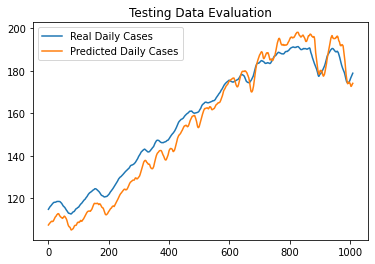

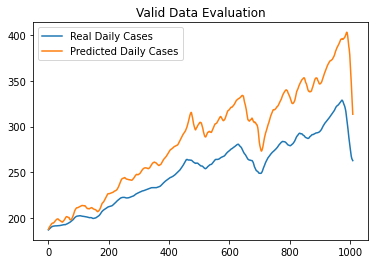

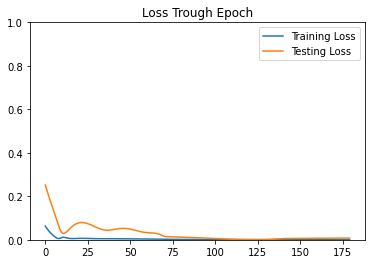

In [0]:
#Evaluation
test_evaluation(model, X_test, y_test, scaler, 'Testing Data')
test_evaluation(model, X_valid, y_valid, scaler, 'Valid Data')

plot_loss(train_hist, test_hist)